In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader


In [2]:
print('Cuda is available:',torch.cuda.is_available())
print('Running on device:',torch.cuda.get_device_name(0))

Cuda is available: True
Running on device: NVIDIA GeForce GTX 1060 6GB


## Investigating the Training Data

The Position-Specific Scoring Matrix (PSSM) encodes the likelihood of observing each amino acid at every position within a protein sequence, derived from multiple sequence alignments. In our dataset, the PSSM probability values are already formatted appropriately for training. They span a range from 0 to 1, where 0 indicates no likelihood and 1 signifies absolute likelihood. 

The secondary structure of a protein is influenced by a combination of the amino acid sequence, local interactions, and the overall folding landscape of the protein. Using convolutional layers to assess the local interactions should allow the model to predict the secondry stucture.

In [3]:
single_test = pd.read_csv('test/1A0S_1_P.csv')
single_train = pd.read_csv('train/1A0A_3_A.csv')
print('Length of arbitary test sequence',len(single_test))
print('Length of arbitary train sequence',len(single_train))
single_test

Length of arbitary test sequence 413
Length of arbitary train sequence 63


,RES_NUM,AMINO_ACID,A,C,D,E,F,G,H,I,...,M,N,P,Q,R,S,T,V,W,Y
0,1,S,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000
1,2,G,0.421277,0.0,0.000000,0.000000,0.000000,0.578723,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,3,F,0.000000,0.0,0.000000,0.000000,0.305865,0.000000,0.000000,0.087602,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.316258,0.123237,0.000000
3,4,E,0.018557,0.0,0.303780,0.319588,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.062543,0.0,0.017182,0.0,0.109966,0.091409,0.050172,0.000000,0.000000
4,5,F,0.000000,0.0,0.000000,0.000000,0.749662,0.000000,0.000000,0.000000,...,0.009472,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.098106,0.006089,0.090663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,409,M,0.209190,0.0,0.000000,0.000000,0.132406,0.000000,0.000000,0.022370,...,0.227932,0.000000,0.0,0.000000,0.0,0.018138,0.087666,0.187424,0.045345,0.008464
409,410,E,0.000000,0.0,0.048632,0.903951,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.047416,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
410,411,T,0.338152,0.0,0.000000,0.000000,0.000000,0.000000,0.037084,0.257071,...,0.027027,0.000000,0.0,0.000000,0.0,0.025141,0.164048,0.106223,0.000000,0.045255
411,412,W,0.000000,0.0,0.000000,0.000000,0.015152,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.984848,0.000000


We can see from the data that they are 20 different amino acids for each position in the sequence, we can also observe that the length of the sequences vary between these two arbitary proteins. Diving a bit deeer we can observe that the maximum sequence length for our dataset is 1733.

In [4]:
train_dir = 'train'
line_counts_train = []
test_dir = 'test'
line_counts_test = []

for file_name in os.listdir(train_dir):
    if file_name.endswith('.csv'):
        file_path = os.path.join(train_dir, file_name)
        df = pd.read_csv(file_path)
        line_count = len(df)
        line_counts_train.append(line_count)
        
for file_name in os.listdir(test_dir):
    if file_name.endswith('.csv'):
        file_path = os.path.join(test_dir, file_name)
        df = pd.read_csv(file_path)
        line_count = len(df)
        line_counts_test.append(line_count)

minimum sequence length: 20
maximum sequence length: 1733


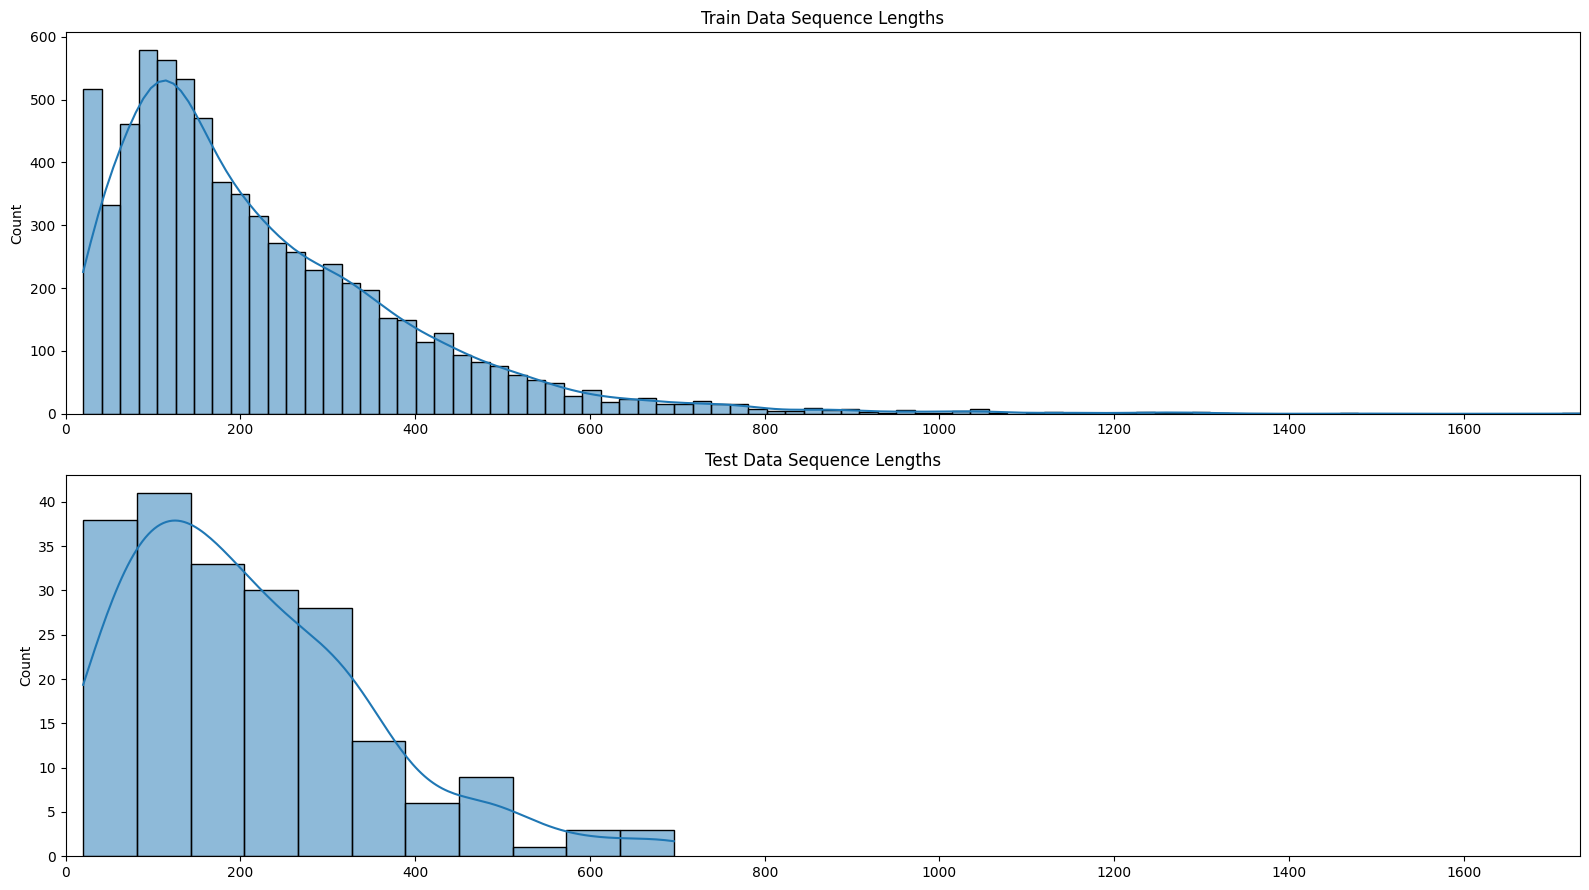

In [5]:
max_sequence_length = max(max(line_counts_train),max(line_counts_test)) 
min_sequence_length = min(min(line_counts_train),min(line_counts_test))

plt.figure(figsize=(16,9))
plt.subplot(2,1,1)
sns.histplot(line_counts_train, kde=True)
plt.xlim(0,max_sequence_length)
plt.title('Train Data Sequence Lengths')
plt.tight_layout()
plt.subplot(2,1,2)
sns.histplot(line_counts_test, kde=True)
plt.xlim(0,max_sequence_length)
plt.title('Test Data Sequence Lengths')
plt.tight_layout()  

print('minimum sequence length:',min_sequence_length)
print('maximum sequence length:',max_sequence_length)


## Initial Processing and Feature Selection

#### One hot encode or use probabilities?
In terms of preprocessing for the nueral network, although one hot encoding of the amino acid could be used, as it has the same dimensionality as the probabilities and less information, therefore the probabilities will be used. This will result in a 20 (number of different amino acids) * max_sequence_length size input layer. 

### Convolution to reduce dimensionality
This will be quite large however by using a conv1D kernel with a stride of 20, the network can reduce the size down by 20 times and hopefully find its own interpretation of what the amino acid percentages mean, before using further convolutional layers to look at the local interactions.

Finally as the training data is in a different order by PBD_ID to the corresponding labels, i will quickly reorder it to mean that the dataset is simpler to create.


In [6]:
test_dir = 'test'
train_dir = 'train'


for file_name in os.listdir(test_dir):
    if file_name.endswith('.csv'):
        new_file_name = file_name.replace('_test', '')
        os.rename(os.path.join(test_dir, file_name), os.path.join(test_dir, new_file_name))

for file_name in os.listdir(train_dir):
    if file_name.endswith('.csv'):
        new_file_name = file_name.replace('_train', '')
        os.rename(os.path.join(train_dir, file_name), os.path.join(train_dir, new_file_name))
        


df = pd.read_csv('labels_train.csv')
df_sorted = df.sort_values('PDB_ID')
df_sorted.to_csv('labels_train_sorted.csv', index=False)


One hot encoding the output for training data and creating a reverse

In [7]:
sec_struct_data = pd.read_csv('labels_train_sorted.csv')
sec_struc_value = sec_struct_data.loc[sec_struct_data['PDB_ID'] == '12AS_1_A', 'SEC_STRUCT'].values[0]

def one_hot_encode_sequence(sequence, max_sequence_length):
    
    # H = 100, E = 010, C = 001
    sequence = sequence.replace('H', '100').replace('E', '010').replace('C', '001')
    sequence = [float(i) for i in sequence]
    
    if len(sequence) < max_sequence_length * 3:
        
        sequence += [0.0] * (max_sequence_length * 3 - len(sequence))
        
    return(torch.tensor(sequence, dtype=torch.float32))


def unencode_output(encoded_sequence,threshold = 0.5):
    sequence = ''
    for i in range(0, len(encoded_sequence), 3):
        if encoded_sequence[i] >= threshold:
            sequence += 'H'
        elif encoded_sequence[i+1] >= threshold:
            sequence += 'E'
        elif encoded_sequence[i+2] >= threshold:
            sequence += 'C'
        else:
            sequence += 'X' # error
    return sequence

## Load the data as the PSSM data

We need to load 1733 rows of 20 probabilites from the file train

In [8]:
class PSSM(Dataset):
    """Position-Specific Scoring Matrix (PSSM) Dataset"""

    def __init__(self, pssm_root_dir, sec_struct_file_path,transform=None):
        """
        Args:
            pssm_root_dir (string): Directory with all the protein PSSM data.
            sec_struct_root_dir (string): Directory with all the protein secondary structure data.            
            transform (callable, optional): Optional transform to be applied on a sample. (not used here)
        """
        self.pssm_root_dir = pssm_root_dir
        self.sec_struct_file_path = sec_struct_file_path
        self.transform = transform
        self.file_list = [file for file in os.listdir(pssm_root_dir) if file.endswith('.csv')]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]

        pssm_csv_file = os.path.join(self.pssm_root_dir, file_name)
        
        pbd_id = os.path.splitext(file_name)[0].split('_')[:-1]
        pbd_id = '_'.join(pbd_id)

        pssm_data = pd.read_csv(pssm_csv_file)
        pssm_data = pssm_data.drop(columns=['RES_NUM','AMINO_ACID'],axis=1)
  
        
        sec_struct_data = pd.read_csv(self.sec_struct_file_path)
        sec_struc_value = sec_struct_data.loc[sec_struct_data['PDB_ID'] == pbd_id, 'SEC_STRUCT']
        encoded_sec_struc = one_hot_encode_sequence(sec_struc_value,max_sequence_length)
              
        
        num_zeros = max_sequence_length - len(pssm_data)
        
        if num_zeros > 0:

            df_zeros = pd.DataFrame(0, index=range(num_zeros), columns=pssm_data.columns)
            pssm_data = pd.concat([pssm_data, df_zeros], ignore_index=True)
            
        pssm_data = pssm_data.to_numpy().flatten()
        pssm_data = torch.tensor(pssm_data, dtype=torch.float32)
                                

        sample = {
            'PDB_ID': pbd_id,
            'PSSM_Data': pssm_data,
            'Second Structure Data':encoded_sec_struc
        }

        if self.transform:
            sample = self.transform(sample)

        return sample


dataset = PSSM(pssm_root_dir='/home/jamiemilsom/Deep_Learning_MSc/Kaggle/PSSM_Profiles/train',sec_struct_file_path='/home/jamiemilsom/Deep_Learning_MSc/Kaggle/PSSM_Profiles/labels_train.csv')
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [9]:
for batch in dataloader:
    pdb_ids = batch['PDB_ID']
    pssm_data = batch['PSSM_Data']
    sec_struct_data = batch['Second Structure Data']
    print('PSSM Data shape:', pssm_data.shape)
    print('Second Structure Data shape:', sec_struct_data.shape)
    break


PSSM Data shape: torch.Size([256, 34660])
Second Structure Data shape: torch.Size([256, 5199])


In [10]:
import collections
import torch.nn as nn

dropout_prob = 0.2
weight_decay = 1e-6
lr=1e-5
momentum=0
dampening=0



input_size = max_sequence_length * 20
output_size = max_sequence_length * 3

hidden_layer_sizes = [max_sequence_length*5, max_sequence_length*3]


ConvNet = nn.Sequential(collections.OrderedDict([
    
    ('conv1', nn.Conv1d(in_channels=1,out_channels=1,kernel_size=20,stride=20,padding=0)),
    ('relu1', nn.ReLU()),
    ('conv2', nn.Conv1d(in_channels=1,out_channels=1,kernel_size=7,stride=1,padding=3)),
    ('relu2', nn.ReLU()),
    
    ('hidden3', nn.Linear(max_sequence_length, hidden_layer_sizes[0])),
    ('relu3', nn.ReLU()),
    ('hidden4', nn.Linear(hidden_layer_sizes[0], hidden_layer_sizes[1])),
    ('relu4', nn.ReLU()),

    ('output', nn.Linear(hidden_layer_sizes[1], output_size)),
    ('softmax', nn.Softmax(dim=1))
]))
    


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ConvNet.parameters(), lr=lr, weight_decay=weight_decay)
print(ConvNet)

Sequential(
  (conv1): Conv1d(1, 1, kernel_size=(20,), stride=(20,))
  (relu1): ReLU()
  (conv2): Conv1d(1, 1, kernel_size=(7,), stride=(1,), padding=(3,))
  (relu2): ReLU()
  (hidden3): Linear(in_features=1733, out_features=8665, bias=True)
  (relu3): ReLU()
  (hidden4): Linear(in_features=8665, out_features=5199, bias=True)
  (relu4): ReLU()
  (output): Linear(in_features=5199, out_features=5199, bias=True)
  (softmax): Softmax(dim=1)
)


In [11]:
def train_model(model, dataloader, loss_fn, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, batch in enumerate(dataloader):
            pssm_data = batch['PSSM_Data']
            sec_struct_data = batch['Second Structure Data']
            pssm_data = pssm_data.unsqueeze(1).to(device='cuda')
            sec_struct_data = sec_struct_data.unsqueeze(1).to(device='cuda')

            optimizer.zero_grad()
            outputs = model(pssm_data)
            loss = loss_fn(outputs, sec_struct_data)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print('Epoch: %d, Loss: %f' % (epoch, running_loss / i))
    print('Finished Training')
    

In [12]:
def test_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            pssm_data = batch['PSSM_Data']
            sec_struct_data = batch['Second Structure Data']
            pssm_data = pssm_data.unsqueeze(1).to(device='cuda')
            sec_struct_data = sec_struct_data.unsqueeze(1).to(device='cuda')
            
            outputs = model(pssm_data)
            
        return outputs, sec_struct_data
            
            

In [13]:
train_model(ConvNet.to(device='cuda'), dataloader, loss_fn, optimizer, num_epochs=1)

Epoch: 0, Loss: 0.000000
Finished Training


In [14]:
outputs, sec_struct_data = test_model(ConvNet.to(device='cuda'), dataloader)

In [17]:
outputs.shape

torch.Size([238, 1, 5199])

In [18]:
sec_struct_data.shape

torch.Size([238, 1, 5199])

In [20]:
output_compare = outputs.flatten()
sec_struct_data_compare = sec_struct_data.flatten()

num_same_indexes = torch.sum(torch.eq(output_compare, sec_struct_data_compare)).item()
print("Percent Correct ", num_same_indexes/len(output_compare) * 100, '%')


Percent Correct  0.0 %


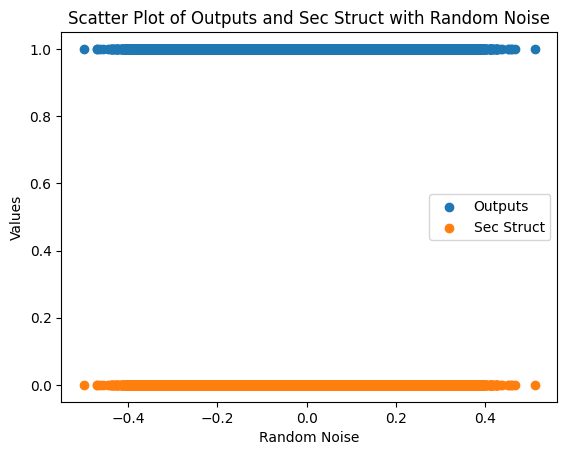

In [22]:
import seaborn as sns
import numpy as np

# Generate random noise for x-axis
noise = np.random.normal(0, 0.1, size=outputs.flatten().shape)

# Create scatter plot
plt.scatter(noise, outputs.flatten().cpu().numpy(), label='Outputs')
plt.scatter(noise, sec_struct_data.flatten().cpu().numpy(), label='Sec Struct')
plt.legend()
plt.xlabel('Random Noise')
plt.ylabel('Values')
plt.title('Scatter Plot of Outputs and Sec Struct with Random Noise')
plt.show()
